### 筆記


In [3]:
import numpy as np

def im2col(input_feat: np.ndarray, N, kh, kw, out_h, out_w, stride):
    im2col_feat = []
    for n in range(N):
        for ih in range(out_h):
            for iw in range(out_w):
                im2col_feat.append(input_feat[n, :, stride * ih:stride * ih + kh, stride * iw:stride * iw + kw])
                # each element -> (C, kh, kw)
    # input_feat -> (N*out_h*out_w, C, kh, kw)

    return np.array(im2col_feat).reshape(N * out_h * out_w, -1)

def convolution(input_feat: np.ndarray, filter: np.ndarray, kh, kw, stride=1, padding=0, bias=None):
    '''
    input_feat: (N, C, H, W)
    filter: (out_C, in_C, kH, kw)
    bias: (out_C, 1)
    '''
    N, C, H, W = input_feat.shape
    out_h = int((H - kh + 2 * padding) // stride) + 1
    out_w = int((W - kw + 2 * padding) // stride) + 1
    out_c = filter.shape[0]
    
    if padding:
        input_feat = np.pad(input_feat, ((0, 0), (0, 0), (padding, padding), (padding, padding)), 'constant', constant_values=0)

    im2col_feat = im2col(input_feat, N, kh, kw, out_h, out_w, stride)
    # im2col -> (N*out_h*out_w, C*kh*kw)

    filter = filter.reshape(out_c, -1)
    # filter -> (out_c, C*kh*kw)

    # w @ x.T
    # w -> (out_c, C*kh*kw)
    # x.T -> (C*kh*kw, N*out_h*out_w)
    if isinstance(bias, np.ndarray):
        out_feat = filter @ im2col_feat.T + bias
    else:
        out_feat = filter @ im2col_feat.T
    # out_feat -> (out_c, N*out_h*out_w)
    
    # 直接將 (out_c, N*out_h*out_w) reshape 成 (N, out_c, out_h, out_w) 會產生順序錯亂
    # 所以先將 (out_c, N*out_h*out_w) 拆成 (out_c, N, out_h, out_w) 後再 permute
    # out_feat -> (N, out_c, out_h, out_w)
    return out_feat.reshape(out_c, N, out_h, out_w).transpose(1, 0, 2, 3)
    # return out_feat.T.reshape(N, out_h, out_w, out_c).transpose(0, 3, 1, 2)
   
    
            

In [4]:
import torch
import torch.nn.functional as F

# input feat (c, h, w) -> (3, 3, 3)
# filter (out_c, in_c, kh, kw) -> (3, 3, 2, 2)
# bias (out_c, 1)
bs = 2
feat_h = 3
feat_w = 3
kh = 2
kw = 2
in_c = 3
out_c = 3
padding = 0
stride = 1

input_feat = np.random.randint(0, 20, size=(bs, in_c, feat_h, feat_w)).astype(np.float32)
filter = np.random.randint(0, 5, size=(out_c, in_c, kh, kw)).astype(np.float32)
# bias = np.random.randint(0, 5, size=(2, 1))
bias = np.zeros((out_c, 1), dtype=np.float32)

out = convolution(input_feat, filter, kh=kh, kw=kw, stride=stride, padding=padding, bias=bias)

# 與 pytorch 的實現方法對照結果
out_t = F.conv2d(torch.tensor(input_feat), torch.tensor(filter), stride=stride, padding=padding, bias=torch.tensor(bias).squeeze(1))


print(f'input feat:\n{input_feat}')
print('======================')
print(f'filter\n:{filter}')
print('======================')
print(f'my out:\n{out}')
print(f'torch out:\n{out_t.numpy()}')
np.allclose(out, out_t)



input feat:
[[[[14.  1. 15.]
   [ 9. 12. 13.]
   [ 4.  7.  5.]]

  [[ 6. 11.  1.]
   [19. 16. 13.]
   [ 8.  2.  0.]]

  [[15. 19.  4.]
   [ 7.  1.  8.]
   [ 8.  0.  6.]]]


 [[[ 0.  7.  6.]
   [17. 18.  6.]
   [ 3. 10. 18.]]

  [[16. 17. 11.]
   [14. 10.  6.]
   [ 8.  2.  1.]]

  [[ 0. 12.  6.]
   [ 5.  5. 14.]
   [ 0.  5.  7.]]]]
filter
:[[[[1. 0.]
   [4. 0.]]

  [[1. 4.]
   [4. 0.]]

  [[1. 0.]
   [4. 0.]]]


 [[[0. 1.]
   [3. 0.]]

  [[1. 4.]
   [2. 1.]]

  [[3. 4.]
   [4. 2.]]]


 [[[0. 2.]
   [4. 4.]]

  [[3. 0.]
   [2. 3.]]

  [[0. 2.]
   [1. 0.]]]]
my out:
[[[[219. 151.]
   [179. 117.]]

  [[283. 204.]
   [182. 153.]]

  [[235. 243.]
   [157. 142.]]]


 [[[228. 212.]
   [120. 125.]]

  [[258. 255.]
   [144. 180.]]

  [[289. 214.]
   [162. 194.]]]]
torch out:
[[[[219. 151.]
   [179. 117.]]

  [[283. 204.]
   [182. 153.]]

  [[235. 243.]
   [157. 142.]]]


 [[[228. 212.]
   [120. 125.]]

  [[258. 255.]
   [144. 180.]]

  [[289. 214.]
   [162. 194.]]]]


True

In [5]:
from my_mlp import MLP, ReLU, Softmax, CrossEntropyLoss
import torch.nn as nn

class MyModel(MLP):
    def __init__(self, 
                 in_channel: int,
                 out_channel: int,
                 kernel_size: tuple,
                 stride: int,
                 padding: int,
                 bias=False
                 ):
        

        kh, kw = kernel_size
        self.kernel_size = kernel_size

        params_set_list = [(in_channel * kh * kw, out_channel, ReLU),
                           (8 * 26 * 26, 10, Softmax)]
        self.params = self.weight_init(params_set_list)
        self.velocity = {
            'w': [np.zeros_like(w) for w in self.params['w']],
            'b': [np.zeros_like(b) for b in self.params['b']]
        }
        self.stride = stride
        self.padding = padding
        
    

    def im2col(self, input_feat: np.ndarray, N, kh, kw, out_h, out_w, stride):
        im2col_feat = []
        for n in range(N):
            for ih in range(out_h):
                for iw in range(out_w):
                    im2col_feat.append(input_feat[n, :, stride * ih:stride * ih + kh, stride * iw:stride * iw + kw])
                    # each element -> (C, kh, kw)
        # input_feat -> (N*out_h*out_w, C, kh, kw)

        return np.array(im2col_feat).reshape(N * out_h * out_w, -1)

    def convolution(self, input_feat: np.ndarray, filter: np.ndarray, kernel_size: tuple, stride=1, padding=0, bias=None):
        '''
        input_feat: (N, C, H, W)
        filter: (out_C, in_C, kH, kw)
        bias: (out_C, 1)
        '''
        N, C, H, W = input_feat.shape
        kh, kw = kernel_size
        out_h = int((H - kh + 2 * padding) // stride) + 1
        out_w = int((W - kw + 2 * padding) // stride) + 1
        out_c = filter.shape[1] 
        self.out_h = out_h
        self.out_w = out_w
        # 這裡定義的 filter dim 與原本相反，看 weight init 定義
        
        if padding:
            input_feat = np.pad(input_feat, ((0, 0), (0, 0), (padding, padding), (padding, padding)), 'constant', constant_values=0)

        im2col_feat = self.im2col(input_feat, N, kh, kw, out_h, out_w, stride)
        # im2col -> (N*out_h*out_w, C*kh*kw)


        # x @ w  
        # x -> (N*out_h*out_w, C*kh*kw)
        # w -> (C*kh*kw, out_c) note: 看 weight init 定義
        if isinstance(bias, np.ndarray):
            out_feat = (im2col_feat @ filter + bias).T
        else:
            out_feat = (im2col_feat @ filter ).T
        # out_feat -> (out_c, N*out_h*out_w)
        
        # 直接 reshape 成 (N, out_c*out_h*out_w) 會產生順序錯亂
        # 所以先將 dim2 的 out_c*out_h*out_w 拆開後再 permute
        # out_feat -> (N, out_c, out_h, out_w)
        return out_feat.reshape(out_c, N, out_h, out_w).transpose((1, 0, 2, 3))

    def forward(self, params: dict, X) -> dict:
        forward_saved = {'I': [], 'Y': []}
        # X shape: (N, C, H, W)
        
        for idx, (w, b, act_func) in enumerate(zip(params['w'], params['b'], params['act_func'])):
            if idx == 0:
                I = self.convolution(X, w, self.kernel_size, self.stride, self.padding, b)
            else:
                # I = self.convolution(Y, w, self.kernel_size, self.stride, self.padding, b)
                # flatten
                Y = Y.reshape(X.shape[0], -1)
                I = np.matmul(Y, w) + b
            Y = act_func.forward(I)
            forward_saved['I'].append(I)
            forward_saved['Y'].append(Y)

        return forward_saved
    
    def backward(self, params: dict, forward_val: dict, input_feat, label) -> dict:

        params_delta = {'W': [], 'b': []}

        bs = input_feat.shape[0]
        norm_factor = 1 / bs
        num_layers = len(params['w'])

        for idx, (Y, I, w, act_func) in enumerate(zip(forward_val['Y'][::-1], 
                                                      forward_val['I'][::-1],
                                                      params['w'][::-1], params['act_func'][::-1])):
            if idx == 0:
                delta = (Y - label) * act_func.backward(I)
            else:
                # delta[n+1] -> (bs, n_layer[n+1]), next_layer_w.T -> (n_layer[n+1], n_layer[n])
                # delta = np.matmul(delta, next_layer_w.T) * act_func.backward(I)
                # delta[n] -> (bs, n_layer[n])

                # I -> (N, C, H, W) => (C, N*H*W) = (8, 2 * 26 * 26)
                # np.matmul(delta, next_layer_w.T) -> (2, 8 * 26 * 26) => (8, 2 * 26 * 26)
                delta = np.matmul(delta, next_layer_w.T) * act_func.backward(I.reshape(bs, -1))
                # TODO
            
            if idx == num_layers - 1:
                # prev_layer_Y -> (N*out_h*out_w, C*kh*kw) = (2 * 26 * 26, 1 * 3 * 3)
                prev_layer_Y = self.im2col(input_feat, bs, kh, kw, self.out_h, self.out_w, self.stride)
            else:
                prev_layer_Y = forward_val['Y'][::-1][idx+1]
         
            # prev_layer_Y.T -> (n_layer[n-1], bs)
            # delta -> (bs, n_layer[n])
            dW = norm_factor * np.matmul(prev_layer_Y.T, delta)    
            db = norm_factor * np.sum(delta, axis=0, keepdims=True)
    
            params_delta['W'].append(dW)
            params_delta['b'].append(db)
            next_layer_w = w

        return params_delta
    

ImportError: cannot import name 'ReLU' from 'my_mlp' (/media/eddy/炫選酷碟區/研究所作業/113-1類神經網路/nn_hw/practice/my_mlp.py)

In [ ]:
input_feat = np.random.randint(0, 255, size=(2, 1, 28, 28)) / 255
myconv = MyModel(1, 8, (3, 3), 1, 0)

my_res_trans = myconv.forward(myconv.params, input_feat)['I'][0]
my_res = convolution(input_feat, myconv.params['w'][0].T, 3, 3, 1, 0, myconv.params['b'][0].T)

print(np.allclose(my_res_trans, my_res))

print(my_res_trans.shape)

True
(2, 8, 26, 26)


In [ ]:
myconv.forward(myconv.params, input_feat)['Y'][1]
# my_res_trans

In [13]:
np.prod((1, 3, 5))

15

In [1]:
from my_mlp import MLP, CrossEntropyLoss
from my_nn_lib import ReLU, Softmax, LeckyReLU, Linear, MyModule

class MyModel(MLP):
    def __init__(self, layer_list):
        self.layers = layer_list

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X
    
    def backward(self, X, label):

        idx_maxlayer = len(self.layers)-1
        dLdZ = label

        for idx in range(idx_maxlayer, -1, -1):
            # 倒敘遍歷

            dLdZ = self.layers[idx].backward(delta=dLdZ)
            
    
    def update_params(self, opt_params):
        for layer in self.layers:
            layer.update_params(opt_params)
        
    def get_pred(self, X, with_onehot=False):
        pred = self.forward(X)
        if with_onehot:
            return pred
        return np.argmax(pred, axis=1)

    def train(self, X_train, Y_train, X_val, Y_val, loss_func, hyper_params: dict, show_plot=False):
        # X_train -> (n_samples, n_features)
        # Y_train -> (n_samples, n_classes) one-hot 
        
        # params = self.weight_init(self.params_set_list)

        n_samples = X_train.shape[0]

        # 將 train data 打包成 batch
        X_batch_all, Y_batch_all = self.pack_to_batch(X_train, Y_train, hyper_params['batch_size'], n_samples)
        
        train_loss_arr = []
        val_loss_arr = []
        
        val_acc_arr = []

        for i in range(hyper_params['epoch']):
            loss = 0
            for X_batch, Y_batch in zip(X_batch_all, Y_batch_all):
                # 單個 batch 訓練過程
                # 1. 前向傳播
                # 2. 反向傳播
                # 3. 更新權重   
                self.forward(X_batch)
                self.backward(X_batch, Y_batch)
                self.update_params({'lr': hyper_params['lr'], 'alpha': hyper_params['alpha']})
                loss += loss_func.cal_loss(self.get_pred(X_batch, with_onehot=True), Y_batch)
              
            # print("Epoch: ", i)
            # print('Loss:', round(loss, 2))

            predictions = self.get_pred(X_val)
            # print('Val Acc:', round(get_accuracy(predictions, Y_val), 2))
            
            train_loss_arr.append(loss / n_samples)

            # 取 output layer 經過 activation function 的結果為 prediction
            val_loss_arr.append(loss_func.cal_loss(self.get_pred(X_val, with_onehot=True), Y_val) / len(X_val))
            val_acc_arr.append(self.calculate_acc(predictions, Y_val))

        if show_plot:
            self.plot_loss_acc(train_loss_arr, val_loss_arr, val_acc_arr)

        return train_loss_arr, val_loss_arr, val_acc_arr

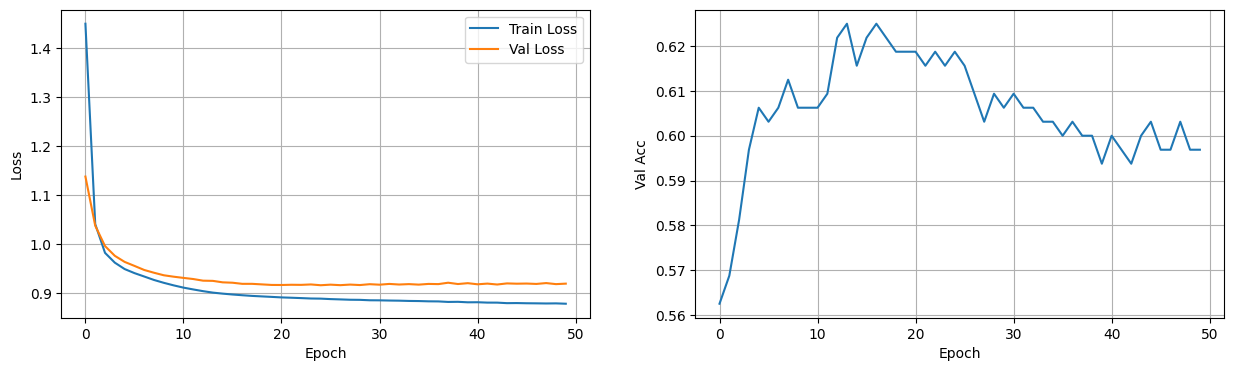

In [9]:
import numpy as np

# 固定隨機種子，確保同參數下每次結果都相同
np.random.seed(1)

def wine():
    with open('data/winequality-red.csv') as f:
        # 跳過 first row (標籤名稱)
        data = f.readlines()[1:]

    data = [line.strip().split(',') for line in data]

    data = np.array(data)
    labels = []

    # 最後一個 column 為 label
    classes = np.unique(data[:, -1])

    # 將 label 做 one-hot encoding
    for d in data:
        for cls in classes:
            if d[-1] == cls:
                one_hot = np.zeros(len(classes))
                one_hot[classes.tolist().index(cls)] = 1
                labels.append(one_hot)
    return data, labels

def iris():
    with open('data/Iris.csv') as f:
    # 跳過 first row (標籤名稱)
        data = f.readlines()[1:]

    data = [line.strip().split(',')[1:] for line in data]
    data = np.array(data)
    labels = []

    classes = np.unique(data[:, 4])

    # 將 label 做 one-hot encoding
    for d in data:
        for cls in classes:
            if d[4] == cls:
                one_hot = np.zeros(len(classes))
                one_hot[classes.tolist().index(cls)] = 1
                labels.append(one_hot)
    return data, labels

# data, labels = iris()
data, labels = wine()
# 將 input features 與 labels 從原始資料中分離
inputs = data[:, :-1].astype(np.float32)
labels = np.array(labels)

# 對 input features 做標準化
inputs = (inputs - np.mean(inputs, axis=0)) / np.std(inputs, axis=0)

# 打亂數據
idx = np.random.permutation(len(inputs))

X_data = inputs[idx]
Y_data = labels[idx]

# 設定 train set 和 val set 的比例 (80% train, 20% val)
train_size = int(len(X_data) * 0.80)


X_train, Y_train = X_data[:train_size], Y_data[:train_size]
X_val, Y_val = X_data[train_size:], Y_data[train_size:]

hyper_params = {
    'lr': 0.01,
    'epoch': 50,
    'batch_size': 16,
    'alpha': 0.9
}


model = MyModel([Linear(11, 6), 
                 LeckyReLU(),
                 Linear(6, 6),
                 Softmax()])

# model = MyModel([Linear(4, 3), Softmax()])

params = model.train(X_train, Y_train, X_val, Y_val, CrossEntropyLoss, hyper_params, show_plot=True)
# mlp.kfold(X_data, Y_data, FOLD, SquareLoss, hyper_params)


In [13]:
model.layers[0].params_delta['db']

array([[ 0.04314097,  0.05022808,  0.01004422, -0.01493384, -0.05331739,
         0.11042866]])

In [12]:
import numpy as np

a = np.random.randint(0, 255, size=(5, 5))
b = np.random.randint(0, 5, size=(5, 3))

print(a @ b, np.dot(a, b))


[[2428 1562 1441]
 [1636  983 1396]
 [1096  796 1088]
 [1153  864  932]
 [1306  845 1371]] [[2428 1562 1441]
 [1636  983 1396]
 [1096  796 1088]
 [1153  864  932]
 [1306  845 1371]]


In [13]:
import numpy as np

class Tensor(np.ndarray):
    def __new__(cls, input_array, requires_grad=False):
        # 建立 ndarray 的子類
        obj = np.asarray(input_array).view(cls)
        obj.requires_grad = requires_grad
        obj.grad = None  # 儲存梯度
        obj._grad_fn = None  # 計算梯度的函數
        return obj

    def __array_finalize__(self, obj):
        # 當新 Tensor 被創建時，繼承屬性
        if obj is None: return
        self.requires_grad = getattr(obj, 'requires_grad', False)
        self.grad = getattr(obj, 'grad', None)
        self._grad_fn = getattr(obj, '_grad_fn', None)

    def backward(self, grad_output=None):
        if not self.requires_grad:
            raise RuntimeError("This tensor does not require gradients.")
        
        if grad_output is None:
            grad_output = np.ones_like(self)
        
        if self.grad is None:
            self.grad = grad_output
        else:
            self.grad += grad_output

        if self._grad_fn:
            self._grad_fn(grad_output)

    def __repr__(self):
        return f"Tensor({super().__repr__()}, requires_grad={self.requires_grad})"


In [28]:
b = np.array([[1, 2], [3, 4]])
a = Tensor(b)
a


Tensor(Tensor([[1, 2],
        [3, 4]]), requires_grad=False)

In [29]:
type(a)

__main__.Tensor